[Table of Contents](00.00-Learning-ML.ipynb#Table-of-Contents) &bull; [&larr; *Chapter 2.03 - k-Nearest Neighbours*](02.03-k-Nearest-Neighbours.ipynb) &bull; [*Chapter 2.05 - Logistic Regression* &rarr;](02.05-Logistic-Regression.ipynb)

---

# Chapter 2.04 - Decision Trees

Decision trees are a family of related algorithms which build logical trees to represent data. Once constructed, a tree resembles a flow chart, starting with a single node or decision point, with two or more branches as optional paths. At each decision point, some feature is considered, and the correct branch is selected based on the value of the feature in the context of the logic presented.

For example, the starting node may consider feature $F_1$, with two branches: $F_1 < 4$ and $F_1 >= 4$. If the observation's $F_1$ value is 2, then the first branch is followed. If the observation's $F_1$ value is 27 then the second branch, and so on.

Depending on the branch taken, another decision point may be reached, most likely for a different feature. Sub-branches will typically consider different features even at similar depths (that is, the number of decisions made), but will vary based on the parameters specified for the model to decide how and when to create a new branch.

When the model stops branching, instead of a decision point we have a node (called a leaf) which contains the predicted label for classification. We can take this value as our classifier output for a given new observation.

Decision trees allow us to consider complex relationships between features (unlike Naive Bayes - which assumes each feature is independent), while allowing us to train a model (producing a decision tree from data) for far quicker predictions than achievable with the k-Nearest Neighbours model! 

As a logical structure, decision trees are also straightforward to inspect, reason about and explain! The trade off is that this simplicity is prone to over-fitting - when we create a model that is able to reproduce its training predictions with low error, but has a high error rate on unseen data. In this chapter, we will see one method for resolving this for a given tree.

## Forming a tree

Building a decision tree on given dataset follows a simple, iterative (actually recursive) process. As with the previous classifiers, we start with a dataset which contains multiple features (X's) and set of labels (Y). To build a tree, we want to find the best X to select as the root node to create a split. There are a few strategies for making this selection, but we will focus on one that uses *Gini Impurity*, measures the misclassification of splitting on a split. We want to select the split that minimises misclassification.

Let's revisit an example from when we introduced Naive Bayes classifiers:

| Employment | Default | Count |
|---|---|---|
| FT | N | 59 |
| FT | Y | 1 |
| PT | N | 36 |
| PT | Y | 4 |

To calculate the best split, we first calculate the Gini Index of the whole data:

$$ Gini\ Index\ (GI) = 1 - Prop(value_1)^2 - Prop(value_2)^2 - ... - Prop(value_n)^2 $$

where *Prop* measures the number of observations with the specified target value as a proportion of the total remaining observations.

In this example, we can calculate the base Gini Index of *Default* as $ Gini\ Index = 1 - 0.05^2 - 0.95^2 $

To calculate Gini Impurity, we use a combination of Gini Index calculations:

$$ Impurity = GI(Target) - Prop(split_{left}) \times GI(Target \mid split_{left}) - Prop(split_{right}) \times (Target \mid split_{right}) $$

For a split *s* on *Employment*, where the left node is *FT* and the right node is *PT*, the Gini Impurity is calculated as:

$$ Impurity = 0.095 - 0.4 \times (1 - \frac{36}{40}^2 - \frac{4}{40}^2) - 0.6 \times (1 - \frac{59}{60}^2 - \frac{1}{60}^2) $$

Impurity is calculated like this for all possible splits, and the split resulting is the smallest value is selected as the root node, producing a left and a right branch each with a corresponding subset of the original data. To complete our decision tree, we repeat the same calculations and continue to select splits on smaller and smaller subsets until reaching a stopping condition (such as reaching a maximum tree depth, or when $GI(Target) = 0$ (meaning all labels in the subset are equal).

For features with multiple categories values, splits are typically tested against the various one-vs-rest combinations, and for features with continuous values, these values are typically binned into ranges for testing.

## Overfitting

Trees resulting from the algorithm above are prone to becoming complex and specific to the training obversations, which means they will typically not generalise well. This is called overfitting - where the resulting tree (or model) is over-fitted to our training data.

We can detect overfitting by comparing the performance of the model on the obversations it was constructed on (training data) to the performance on unmodelled observations (testing data). When the training error is less than the testing error, we know that the model is too specific to the training data and did not generalise well to the test data - and so it is overfitted.

Overfitting can be offset by reducing the complexity of a tree, by establishing certain thresholds around the tree depth (or number of splits) and requirements for a split such as the minimum number of resulting observations on either side.

## Cross Validation

Like with any model, we want to build the best decision tree possible - that is, one which generalises well, and not overfitted as described above. If we can make more data available for training, the algorithms (by splitting on a measure such as *Gini impurity*) can possibly induce a better model. As we discovered previously, it's important to keep some amount (say, 20%) of labelled observations separate from the training process, so that we can produce a test score to determine how well the model performs on unseen data. As above, we can detect overfitting when the training error is less than the testing error.

Well, it turns out that we can repeat our 80%/20% training/testing split more than once. For each repeat split, we simply take a different 20% of the data for testing. In fact, by repeating this process 5 times (5-fold) on different 20% tests, we can create 5 models and collectively use the *entire* dataset for training - while still providing a score of how well the model performs on unseen data.

This general process is called *k-fold cross validation*, and in our case $k = 5$.


## Implementing a Decision Tree

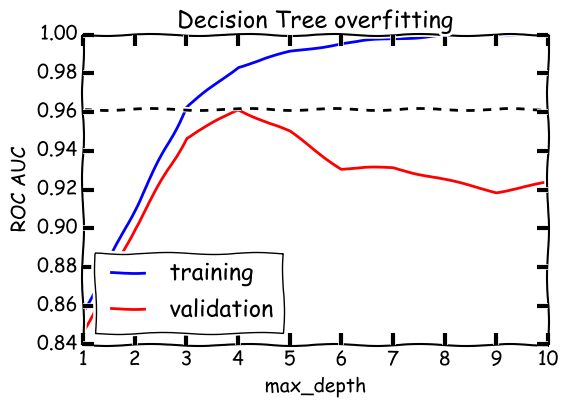

In [83]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.tree import DecisionTreeClassifier
import numpy as np

# create some data and configure a decision tree
X, y = make_classification(n_samples=1000, n_classes=2, n_features=20, n_informative=2)
dt = DecisionTreeClassifier(criterion="gini")

# compute training and validation scores using 5-fold cv, for increasing values of max_depth
max_depth_range = range(1,11)
train_scores, valid_scores = validation_curve(dt, X, y, "max_depth", max_depth_range, scoring="roc_auc", cv=5)

# plot it
%matplotlib inline
import matplotlib.pyplot as plt

plt.xkcd()
plt.plot(max_depth_range, np.mean(train_scores,axis=1), label='training')
plt.plot(max_depth_range, np.mean(valid_scores,axis=1), label='validation')
plt.axhline(y=np.amax(np.mean(valid_scores,axis=1)), color='black', linestyle='--')
plt.title('Decision Tree overfitting')
plt.xlabel('max_depth')
plt.ylabel('ROC AUC')
plt.legend(loc="lower left");

## Feature Reduction

Decision trees can output the importance of features. This is a relative importance based on that particular feature's contribution to the overall tree, and is calculated by weighting the total proportion of observations it impacted and the resulting Gini impurities described above. While we won't go in depth on that calculation here, we can use the results to identify the key decision drivers of our model, and also identify the features which are not very important.

[ 0.02216831  0.01659174  0.01985211  0.78566919  0.05045707  0.00782169
  0.02084568  0.03703256  0.01629217  0.02326947]


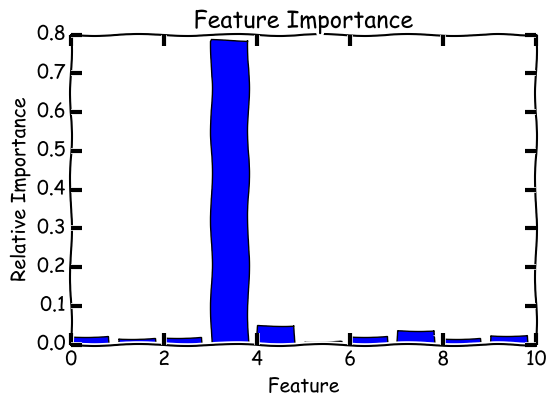

In [103]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

# create some data and run decision tree with 5-fold CV
X, y = make_classification(n_samples=1000, n_classes=2, n_features=10, n_informative=2)
dt = DecisionTreeClassifier(criterion="gini")
dt.fit(X, y)
print(dt.feature_importances_)

# plot it
%matplotlib inline
import matplotlib.pyplot as plt

plt.xkcd()
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Relative Importance')
plt.bar(range(len(dt.feature_importances_)), dt.feature_importances_);

It's clear (usually\*) from the bar chart, which features are and are not important. \* Occasionally the noise introduced by `make_classification` in combination with overfitting in action can heighten the importance of uninformative features.

## Performance with increasing observations

In the last chatper, we noted that kNN performance will decline when the number of observations increases, and that we want to improve this with our decision tree model. To test this, we'll re-run the kNN test, alongside the same test for our decision tree.

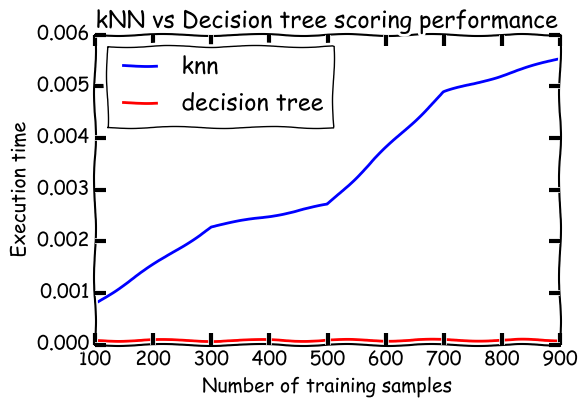

In [115]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import numpy as np

px = []
py1 = []
py2 = []

# this might take a while
for samples in range(100,1000,200):
    
    # create some data and split into training and test sets
    X, y = make_classification(n_samples=samples, n_classes=2, n_features=50, n_informative=25)
    ts = 40/samples
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=42)

    # fit kNN classifier and make predictions
    knn = KNeighborsClassifier(n_neighbors=4)
    knn.fit(X_train, y_train)
    
    # fit decision tree classifier and make predictions
    dt = DecisionTreeClassifier(criterion="gini")
    dt.fit(X_train, y_train)
    
    # this is some Jupyter magic that allows us to capture execution timing
    # this might take a while to run
    knn_result = %timeit -o -q knn.predict_proba(X_test)
    dt_result = %timeit -o -q dt.predict_proba(X_test)
    
    px.append(samples)
    py1.append(knn_result.best)
    py2.append(dt_result.best)

%matplotlib inline
import matplotlib.pyplot as plt

plt.xkcd()
plt.plot(px,py1,label='knn')
plt.plot(px,py2,label='decision tree')
plt.title('kNN vs Decision tree scoring performance')
plt.xlabel('Number of training samples')
plt.ylabel('Execution time')
plt.legend(loc="upper left");

As you can see, scoring time for the decision tree remains uniform and insignificant compared to the kNN classifier.

## What next?

So now we've looked at an algorithm that is able to both consider complex relationships between features, but also create a model on the training step that is powerful enough to reduce scoring time, but can be prone to overfitting without careful attention being given to (hyper) parameters.

One alternative which is less prone to overfitting is the Logistics Regression classifier, which instead of attempting to model complex decision rules within a dataset, instead opts to find the simplest linear boundary between classes.

---

[Table of Contents](00.00-Learning-ML.ipynb#Table-of-Contents) &bull; [&larr; *Chapter 2.03 - k-Nearest Neighbours*](02.03-k-Nearest-Neighbours.ipynb) &bull; [*Chapter 2.05 - Logistic Regression* &rarr;](02.05-Logistic-Regression.ipynb)